In [1]:
# ========================== STEP 1 Libraries ==========================
from google.colab import drive
import zipfile, os, glob, re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json

In [2]:
# ========================== STEP 2 Mount & Unzip ==========================
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Dataset/DATASET.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Mounted at /content/drive


In [3]:
# ========================== STEP 3 Combine CSVs ==========================
csv_files = sorted(glob.glob(os.path.join(extract_path, "*.csv")))
dfs = []

for p in csv_files:
    df = pd.read_csv(p, low_memory=False)
    m = re.search(r'(\d{4})', os.path.basename(p))
    if m:
        df['Year'] = int(m.group(1))
    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True, sort=False)
print("Combined dataset shape:", combined.shape)
print(combined[['Team','Year']].head())

print("All CSV files have been successfully combined.")
print("Combined dataset shape:", combined.shape)
print("First 5 teams in the combined dataset:", combined['Team'].head(5).tolist())
print("Years included in the dataset:", combined['Year'].drop_duplicates().sort_values().tolist()[:5], "...")

Combined dataset shape: (489, 11)
            Team  Year
0        Uruguay  1930
1      Argentina  1930
2  United States  1930
3     Yugoslavia  1930
4          Chile  1930
All CSV files have been successfully combined.
Combined dataset shape: (489, 11)
First 5 teams in the combined dataset: ['Uruguay', 'Argentina', 'United States', 'Yugoslavia', 'Chile']
Years included in the dataset: [1930, 1934, 1938, 1950, 1954] ...


In [4]:
# ========================== STEP 4 Missing Values & Duplicates ==========================
# Count missing values per column
missing_counts = combined.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Percentage of missing values
missing_percent = (combined.isnull().sum() / len(combined)) * 100
print("\nMissing values percentage per column:\n", missing_percent)

# Handle missing values
numeric_cols = combined.select_dtypes(include=['float64', 'int64']).columns
combined[numeric_cols] = combined[numeric_cols].fillna(0)

categorical_cols = combined.select_dtypes(include=['object']).columns
combined[categorical_cols] = combined[categorical_cols].fillna('Unknown')

# Check for duplicates
duplicates = combined.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)
if duplicates > 0:
    combined = combined.drop_duplicates()
    print("Duplicates removed. New shape:", combined.shape)

# Verify final missing values
print("\nMissing values after handling:\n", combined.isnull().sum())


Missing values per column:
 Position           0
Team               0
Games Played       0
Win                0
Draw               0
Loss               0
Goals For          0
Goals Against      0
Goal Difference    0
Points             0
Year               0
dtype: int64

Missing values percentage per column:
 Position           0.0
Team               0.0
Games Played       0.0
Win                0.0
Draw               0.0
Loss               0.0
Goals For          0.0
Goals Against      0.0
Goal Difference    0.0
Points             0.0
Year               0.0
dtype: float64

Number of duplicate rows: 0

Missing values after handling:
 Position           0
Team               0
Games Played       0
Win                0
Draw               0
Loss               0
Goals For          0
Goals Against      0
Goal Difference    0
Points             0
Year               0
dtype: int64


In [5]:
# ========================== STEP 5 Feature Engineering ==========================
# Standardize team names
team_standardization = {
    'USA': 'United States',
    'U.S.A.': 'United States',
    'Korea Republic': 'South Korea',
    'Korea DPR': 'North Korea',
    'Korea': 'South Korea',
    'Soviet Union': 'Russia',
    'Yugoslavia': 'Serbia',
    'Czechoslovakia': 'Czech Republic',
    'East Germany': 'Germany',
    'West Germany': 'Germany',
    'IR Iran': 'Iran',
    'Trinidad & Tobago': 'Trinidad and Tobago',
}

combined['Team'] = combined['Team'].replace(team_standardization)

# Mark inactive/dissolved teams
inactive_teams = ['East Germany', 'FR Yugoslavia', 'Czechoslovakia', 'Soviet Union', 'Bosnia and Herzegovina']
combined['is_active'] = combined['Team'].apply(lambda x: 0 if x in inactive_teams else 1)

# Mark host countries as active
hosts = ['Canada', 'United States', 'Mexico']
combined.loc[combined['Team'].isin(hosts), 'is_active'] = 1

# Label encode team names
team_encoder = LabelEncoder()
combined['Team_Encoded'] = team_encoder.fit_transform(combined['Team'])
team_mapping = dict(zip(team_encoder.classes_, team_encoder.transform(team_encoder.classes_)))

# Basic features
combined['Win_Rate'] = combined['Win'] / combined['Games Played']
combined['Points_Per_Game'] = combined['Points'] / combined['Games Played']
combined['Goal_Ratio'] = combined['Goals For'] / combined['Goals Against'].replace(0,1)
combined['Goal_Difference'] = combined['Goals For'] - combined['Goals Against']
combined['Scoring_Efficiency'] = combined['Goals For'] / (combined['Win'] + combined['Draw'] + combined['Loss'])
combined['Defense_Strength'] = combined['Goals Against'] / combined['Games Played']
combined['Attack_vs_Defense'] = (combined['Goals For'] - combined['Goals Against']) / combined['Games Played']
combined['Unbeaten_Rate'] = (combined['Win'] + combined['Draw']) / combined['Games Played']

feature_cols = ['Win_Rate','Points_Per_Game','Goal_Ratio','Goal_Difference',
                'Scoring_Efficiency','Defense_Strength','Attack_vs_Defense',
                'Unbeaten_Rate','Team_Encoded']

# Clean infinite or NaN values
combined.replace([float('inf'), -float('inf')], 0, inplace=True)
combined.fillna(0, inplace=True)

# Verify standardized teams, inactive teams, and new features
print("Unique teams after standardization:", sorted(combined['Team'].unique()))
print("Inactive teams flagged:", combined[combined['is_active']==0]['Team'].unique())
print(combined[['Team','Year','is_active'] + feature_cols].head())

Unique teams after standardization: ['Algeria', 'Angola', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Bulgaria**', 'Cameroon', 'Canada', 'Chile', 'China PR', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Czech Republic', 'Denmark', 'Dutch East Indies', 'Ecuador', 'Egypt', 'El Salvador', 'England', 'FR Yugoslavia', 'France', 'Germany', 'Ghana', 'Greece', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Iran', 'Iraq', 'Israel*', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Kuwait', 'Mexico', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria', 'North Korea', 'Northern Ireland', 'Norway', 'Panama', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Republic of Ireland', 'Romania', 'Russia', 'Saudi Arabia', 'Scotland', 'Senegal', 'Serbia', 'Serbia and Montenegro', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Togo', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'United Arab Emira

In [6]:
# ========================== STEP 6 Train/Test Split ==========================
# Target variable: categorize positions
def categorize_position(pos):
    if pos in [1,2,3]: return 'Top'
    elif 4 <= pos <= 16: return 'Middle'
    else: return 'Bottom'

combined['Position_Category'] = combined['Position'].apply(categorize_position)

# Features & target
X = combined[feature_cols]
y = combined['Position_Category']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())



X_train shape: (391, 9)
X_test shape: (98, 9)
y_train distribution:
 Position_Category
Middle    223
Bottom    115
Top        53
Name: count, dtype: int64
y_test distribution:
 Position_Category
Middle    56
Bottom    29
Top       13
Name: count, dtype: int64


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Random Forest Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.9, 'max_features': 0.8, 'max_depth': 10}
Train Accuracy: 89.26%
Test Accuracy: 84.69%
OOB Score (Out-of-Bag): 0.8235
Test F1 Score: 0.8164

Classification Report:

              precision    recall  f1-score   support

         Top       0.79      0.93      0.86        29
      Middle       0.87      0.86      0.86        56
      Bottom       0.89      0.62      0.73        13

    accuracy                           0.85        98
   macro avg       0.85      0.80      0.82        98
weighted avg       0.85      0.85      0.84        98



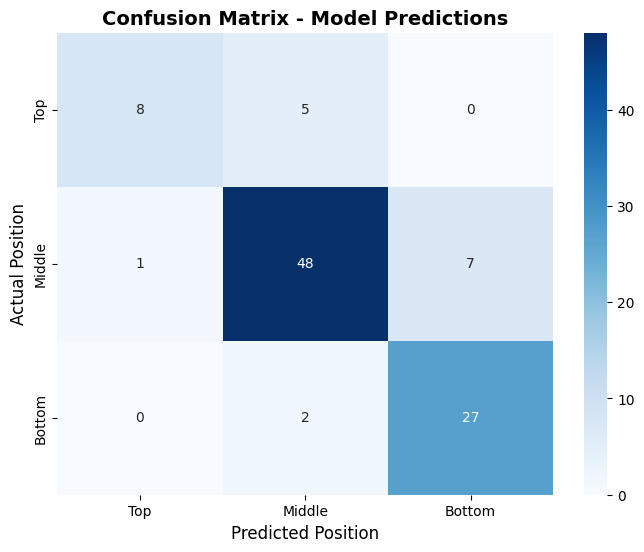


Prediction Confidence Statistics:
Average Prediction Confidence: 0.7698
Maximum Prediction Confidence: 0.9952


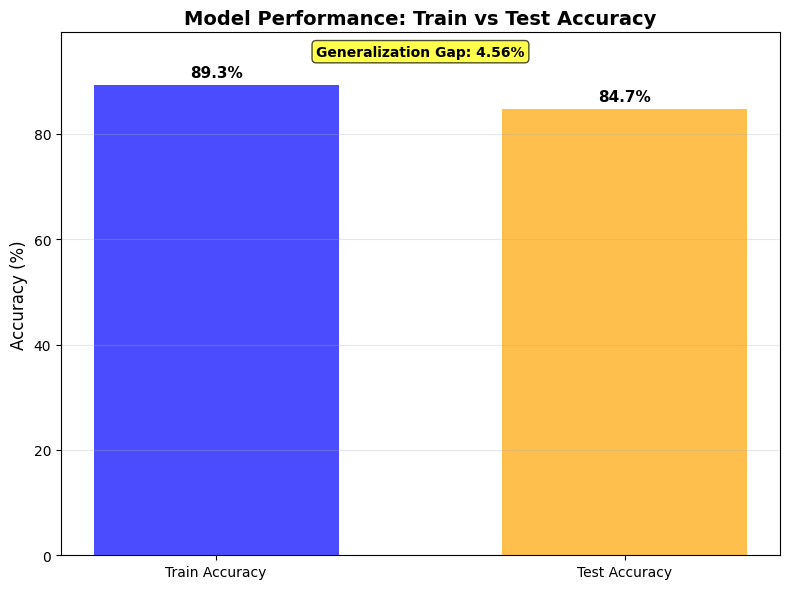

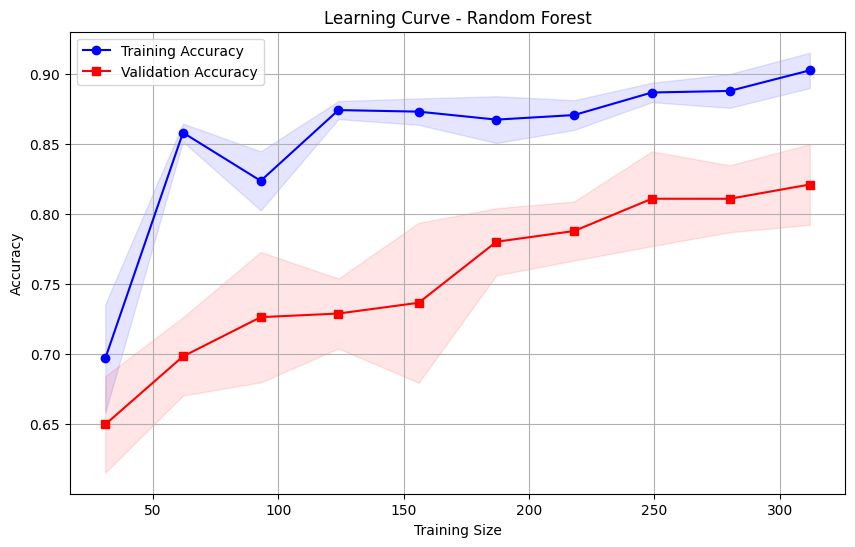


Learning Curve Analysis:
Training Size: 31 | Train Accuracy: 0.697 ± 0.039 | Val Accuracy: 0.650 ± 0.034
Training Size: 62 | Train Accuracy: 0.858 ± 0.006 | Val Accuracy: 0.698 ± 0.028
Training Size: 93 | Train Accuracy: 0.824 ± 0.021 | Val Accuracy: 0.726 ± 0.047
Training Size: 124 | Train Accuracy: 0.874 ± 0.006 | Val Accuracy: 0.729 ± 0.025
Training Size: 156 | Train Accuracy: 0.873 ± 0.009 | Val Accuracy: 0.737 ± 0.057
Training Size: 187 | Train Accuracy: 0.867 ± 0.017 | Val Accuracy: 0.780 ± 0.024
Training Size: 218 | Train Accuracy: 0.871 ± 0.011 | Val Accuracy: 0.788 ± 0.021
Training Size: 249 | Train Accuracy: 0.887 ± 0.007 | Val Accuracy: 0.811 ± 0.034
Training Size: 280 | Train Accuracy: 0.888 ± 0.012 | Val Accuracy: 0.811 ± 0.024
Training Size: 312 | Train Accuracy: 0.903 ± 0.013 | Val Accuracy: 0.821 ± 0.029


In [7]:
# ============ STEP 7 Random Forest Training ==============

# Define class weights to slightly boost Bottom class
class_weights = {'Top': 1, 'Middle': 1, 'Bottom': 1.5}

# Initialize Random Forest with OOB
rf = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.6, 0.8],
    'max_samples': [0.7, 0.8, 0.9]
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit model
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Random Forest Best Parameters: {rf_random.best_params_}")
print(f"Train Accuracy: {accuracy_score(y_train, best_rf.predict(X_train))*100:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"OOB Score (Out-of-Bag): {best_rf.oob_score_:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# ============ CONFUSION MATRIX ==============

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Top', 'Middle', 'Bottom']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Top','Middle','Bottom'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Top','Middle','Bottom'],
            yticklabels=['Top','Middle','Bottom'])
plt.title('Confusion Matrix - Model Predictions', fontsize=14, fontweight='bold')
plt.ylabel('Actual Position', fontsize=12)
plt.xlabel('Predicted Position', fontsize=12)
plt.show()

# Prediction Confidence
y_pred_proba = best_rf.predict_proba(X_test)
avg_confidence = np.mean(np.max(y_pred_proba, axis=1))
max_confidence = np.max(np.max(y_pred_proba, axis=1))

print(f"\nPrediction Confidence Statistics:")
print(f"Average Prediction Confidence: {avg_confidence:.4f}")
print(f"Maximum Prediction Confidence: {max_confidence:.4f}")

# ============ TRAIN VS TEST ACCURACY ==============
train_accuracy = accuracy_score(y_train, best_rf.predict(X_train)) * 100
test_accuracy = accuracy

plt.figure(figsize=(8, 6))
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']

bars = plt.bar(labels, accuracies, color=['blue', 'orange'], alpha=0.7, width=0.6)
plt.title('Model Performance: Train vs Test Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, max(accuracies) + 10)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add generalization gap annotation
gap = train_accuracy - test_accuracy
plt.text(0.5, max(accuracies) + 5, f'Generalization Gap: {gap:.2f}%',
        ha='center', va='bottom', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# ============ LEARNING CURVE ==============
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='red', marker='s')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print learning curve results
print("\nLearning Curve Analysis:")
for i, size in enumerate(train_sizes):
    print(f"Training Size: {size:.0f} | Train Accuracy: {train_mean[i]:.3f} ± {train_std[i]:.3f} | Val Accuracy: {val_mean[i]:.3f} ± {val_std[i]:.3f}")



/tmp/ipython-input-54475301.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')


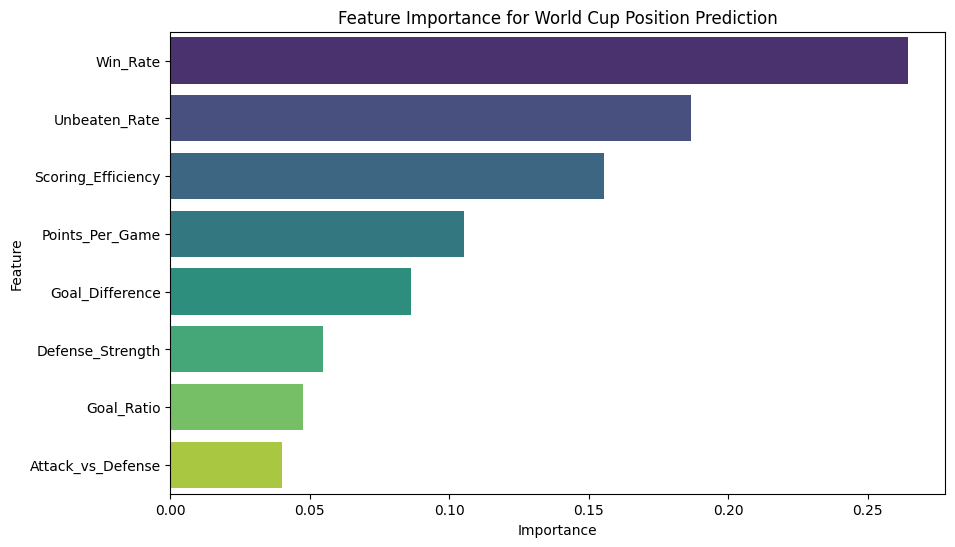

Feature Importance Ranking:
               Feature  Importance
0            Win_Rate    0.264691
7       Unbeaten_Rate    0.186651
4  Scoring_Efficiency    0.155325
1     Points_Per_Game    0.105408
3     Goal_Difference    0.086223
5    Defense_Strength    0.054730
2          Goal_Ratio    0.047714
6   Attack_vs_Defense    0.039985


In [8]:
# ==========================STEP 8 Feature Importance ==========================
importance_features = [f for f in feature_cols if f != 'Team_Encoded']
importances = best_rf.feature_importances_

# Create DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': importance_features,
    'Importance': importances[:len(importance_features)]
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title("Feature Importance for World Cup Position Prediction")
plt.show()
print("Feature Importance Ranking:\n", feat_importance_df)


******* Predicted 2026 World Cup Top 48 Teams *******
                   Team Predicted_Tier Predicted_Position  Performance_Score
0                Brazil            Top           Champion           5.340266
1               Germany            Top          Runner-Up           5.032704
2                 Italy            Top        Third Place           4.534472
3             Argentina         Middle                              4.520567
4                 Spain         Middle                              4.343450
5           Netherlands         Middle                              4.324105
6                Turkey         Middle                              4.261554
7               Hungary         Middle                              4.257140
8              Portugal         Middle                              4.242647
9               England         Middle                              4.151184
10               France         Middle                              4.141862
11              Croati

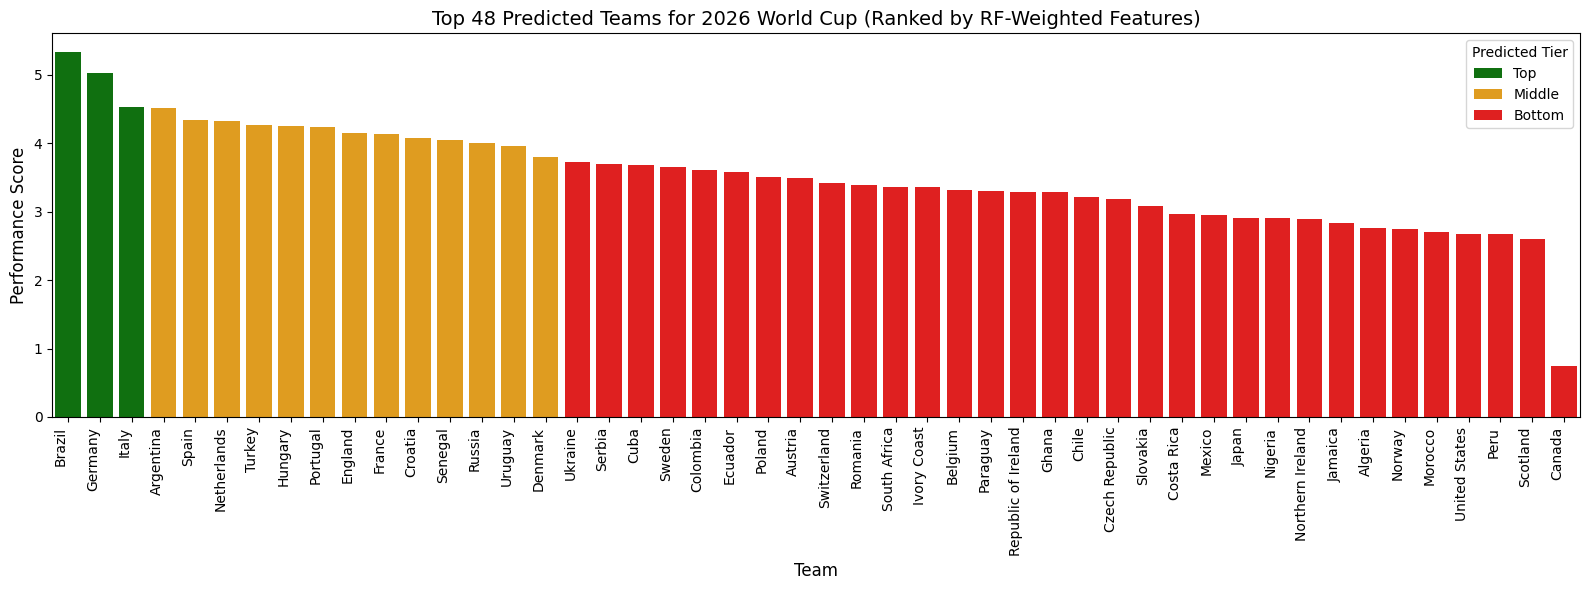

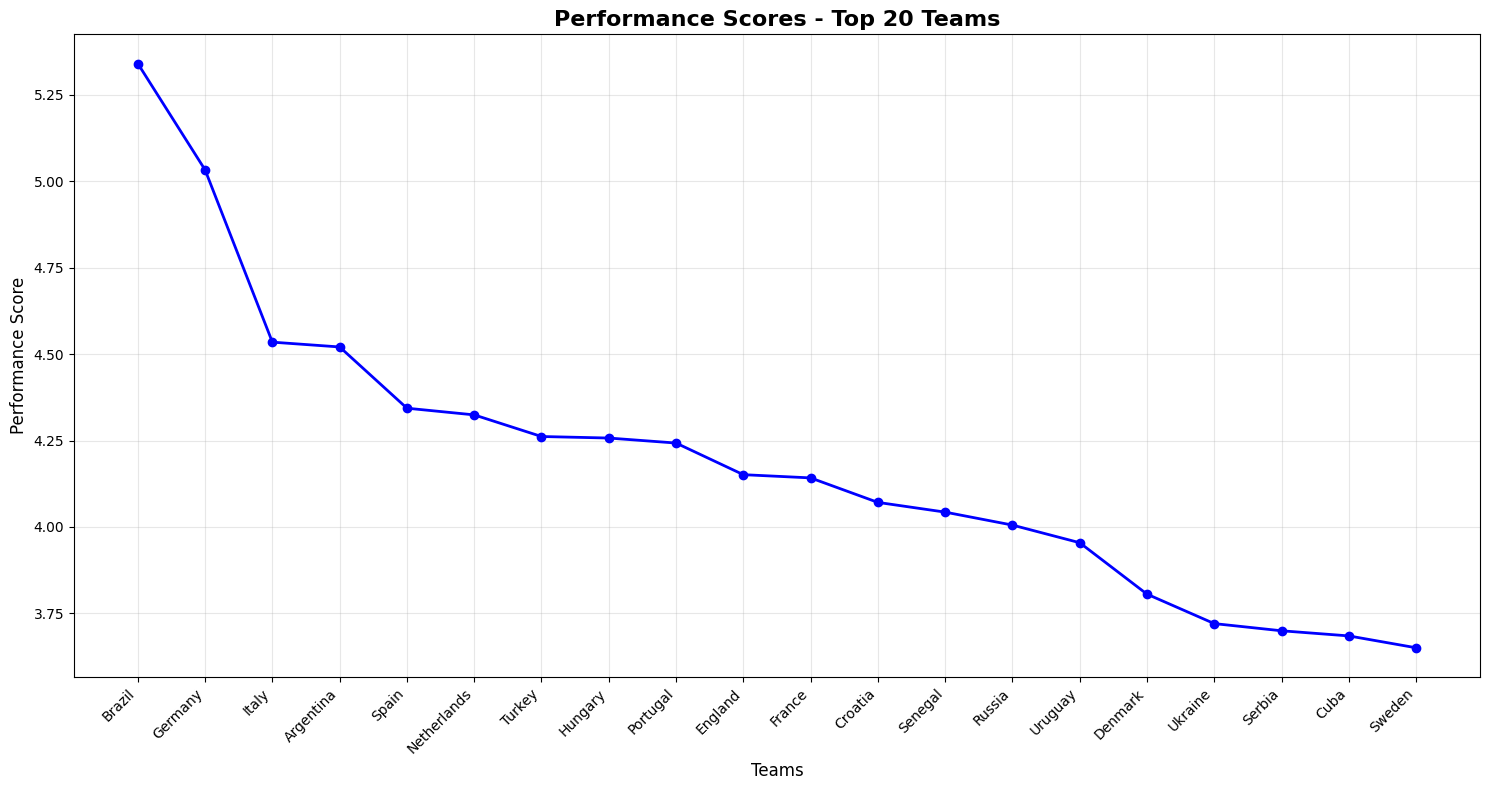

In [9]:
# ========================== STEP 9 2026 Prediction ==========================
# Filter only active teams
active_teams_df = combined[combined['is_active'] == 1].copy()

# Use existing feature_cols from Feature Engineering
X_2026 = active_teams_df[feature_cols]

# Predict category using trained Random Forest
active_teams_df['Predicted_Category'] = best_rf.predict(X_2026)

# Use Random Forest feature importance to weight features
feature_importance = best_rf.feature_importances_

# Remove Team_Encoded from feature importance
feature_names_without_team = [f for f in feature_cols if f != 'Team_Encoded']
importance_without_team = [feature_importance[feature_cols.index(f)] for f in feature_names_without_team]

# Create weighted Performance Score using RF-learned importance
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X_2026.drop('Team_Encoded', axis=1))

# Weight the scaled features by their importance learned by Random Forest
weighted_features = scaled_features * importance_without_team
active_teams_df['Performance_Score'] = weighted_features.sum(axis=1) * 10  # Scale to nice range

# Aggregate team-level performance
team_perf = active_teams_df.groupby('Team').agg({
    'Performance_Score':'mean',
    'Win':'sum',
    'Goals For':'sum',
    'Win_Rate':'mean'
}).reset_index()

# Ensure host countries are included
hosts = ['Canada', 'United States', 'Mexico']
hosts_df = team_perf[team_perf['Team'].isin(hosts)]

# Remaining top teams (excluding hosts) to fill Top 48
remaining_df = team_perf[~team_perf['Team'].isin(hosts)]
top_remaining = remaining_df.sort_values(by='Performance_Score', ascending=False).head(48 - len(hosts))

# Combine hosts + remaining → Top 48
top48_df = pd.concat([hosts_df, top_remaining], ignore_index=True).reset_index(drop=True)

# Sort all 48 teams by Performance Score descending
top48_df_sorted = top48_df.sort_values(by='Performance_Score', ascending=False).reset_index(drop=True)

# Assign Champion, Runner-Up, Third Place
predicted_positions = ['Champion', 'Runner-Up', 'Third Place'] + [''] * (len(top48_df_sorted)-3)
top48_df_sorted['Predicted_Position'] = predicted_positions

# Assign Tier: Top = top3, Middle = next 16, Bottom = remaining
def assign_tier(idx):
    if idx < 3:
        return 'Top'
    elif idx < 16:
        return 'Middle'
    else:
        return 'Bottom'

top48_df_sorted['Predicted_Tier'] = top48_df_sorted.index.map(assign_tier)

# Final dataframe
pred_2026_df = top48_df_sorted[['Team','Predicted_Tier','Predicted_Position','Performance_Score']].copy()

# Print Top 48
print("******* Predicted 2026 World Cup Top 48 Teams *******")
print(pred_2026_df)

# Visualization: Bar plot by Performance Score
plt.figure(figsize=(16,6))
sns.barplot(
    data=pred_2026_df,
    x='Team',
    y='Performance_Score',
    hue='Predicted_Tier',
    dodge=False,
    palette={'Top':'green','Middle':'orange','Bottom':'red'}
)
plt.title('Top 48 Predicted Teams for 2026 World Cup (Ranked by RF-Weighted Features)', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Performance Score', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Predicted Tier')
plt.tight_layout()
plt.show()

# Top 20 teams line graph
top_20 = pred_2026_df.head(20).copy()
plt.figure(figsize=(15, 8))
plt.plot(top_20['Team'], top_20['Performance_Score'], marker='o', linewidth=2, markersize=6, color='blue')
plt.title('Performance Scores - Top 20 Teams', fontsize=16, fontweight='bold')
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Performance Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# ========================== STEP 10: Generate COMPLETE JSON with Teams & Match Predictions ==========================
print(" Generating COMPLETE JSON with Teams & ALL Match Predictions...")

# Create COMPLETE data structure
complete_data = {
    "teams": [],
    "predictions": {}
}

# Add ALL 48 teams with their data
for index, row in pred_2026_df.iterrows():
    team_data = {
        "Team": row['Team'],
        "Performance_Score": round(row['Performance_Score'], 6),
        "Predicted_Tier": row['Predicted_Tier'],
        "Predicted_Position": row['Predicted_Position']
    }
    complete_data["teams"].append(team_data)

print(f" Added {len(complete_data['teams'])} teams")

# Generate ALL match predictions
all_teams = pred_2026_df['Team'].tolist()
all_matchups = list(itertools.combinations(all_teams, 2))

print(f" Generating {len(all_matchups)} match predictions...")

for team1, team2 in all_matchups:
    # Get performance scores
    perf1 = pred_2026_df[pred_2026_df['Team'] == team1]['Performance_Score'].values[0]
    perf2 = pred_2026_df[pred_2026_df['Team'] == team2]['Performance_Score'].values[0]

    # Higher performance ALWAYS wins
    winner = team1 if perf1 >= perf2 else team2

    # Calculate confidence based on performance difference
    max_perf = max(perf1, perf2)
    min_perf = min(perf1, perf2)
    perf_ratio = (max_perf - min_perf) / max_perf
    confidence = 0.5 + (perf_ratio * 0.4)  # 50% to 90% confidence

    # Calculate win probabilities
    total = perf1 + perf2
    team1_win_prob = perf1 / total
    team2_win_prob = perf2 / total

    # Store prediction
    match_key = f"{team1}_vs_{team2}"
    complete_data["predictions"][match_key] = {
        "team1": team1,
        "team2": team2,
        "winner": winner,
        "confidence": round(confidence, 6),
        "probabilities": {
            "team1_win": round(team1_win_prob, 6),
            "team2_win": round(team2_win_prob, 6)
        }
    }

# Save to JSON
output_filename = '2026_worldcup_COMPLETE.json'
with open(output_filename, 'w') as f:
    json.dump(complete_data, f, indent=2)

print(" COMPLETE JSON generated!")
print(f" Teams: {len(complete_data['teams'])}")
print(f" Predictions: {len(complete_data['predictions'])}")

# Download
from google.colab import files
files.download(output_filename)

print(" 2026_worldcup_COMPLETE.json downloaded!")

 Generating COMPLETE JSON with Teams & ALL Match Predictions...
 Added 48 teams
 Generating 1128 match predictions...
 COMPLETE JSON generated!
 Teams: 48
 Predictions: 1128


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 2026_worldcup_COMPLETE.json downloaded!


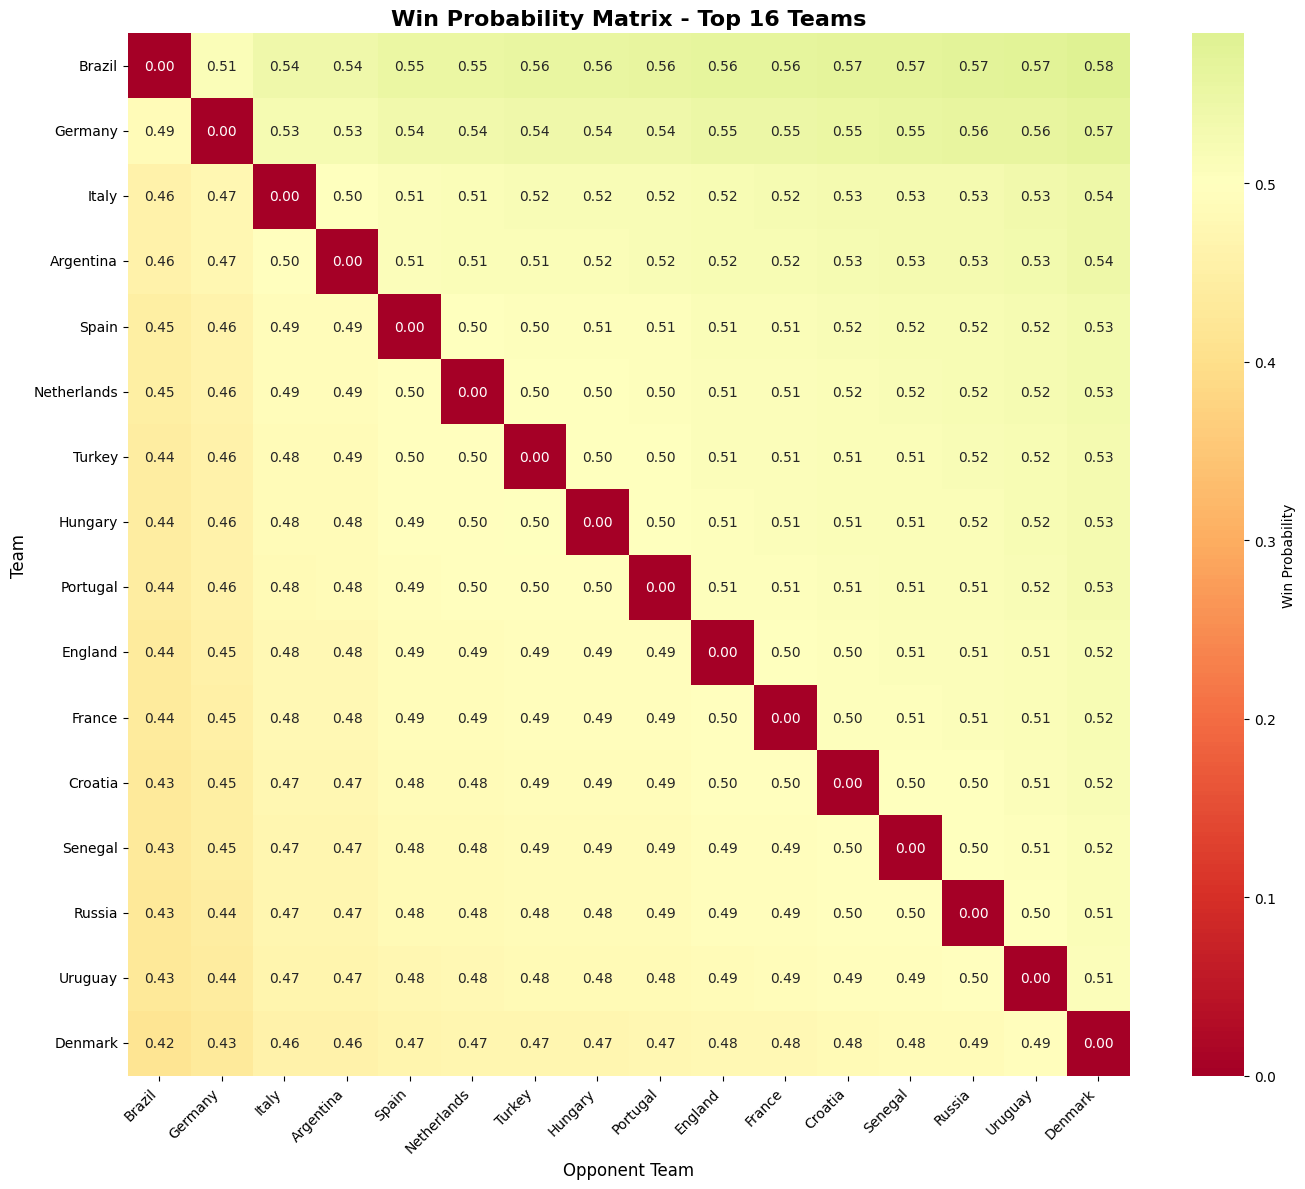

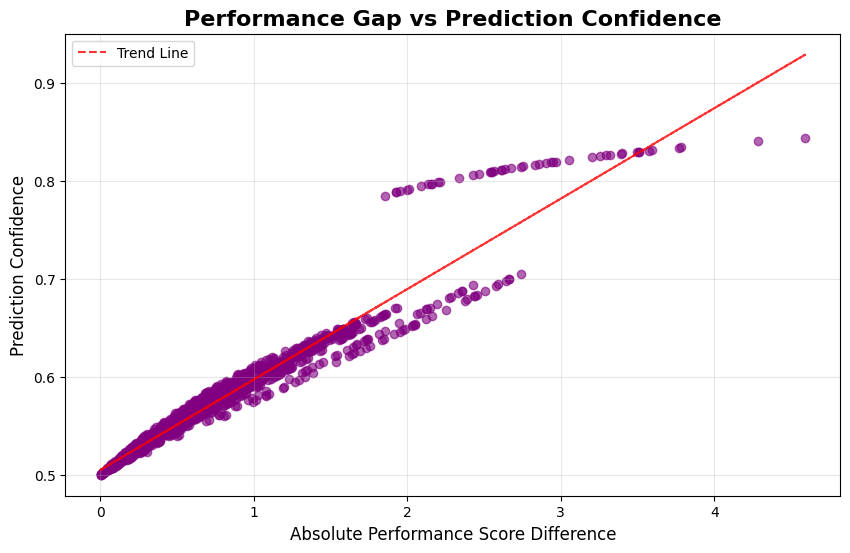

In [11]:
# ========================== STEP 11: Visualize Predictions (Heatmap & Confidence) ==========================
# Select top 16 teams for readable heatmap
top_16_teams = pred_2026_df.head(16)['Team'].tolist()
prob_matrix = np.zeros((16, 16))

for i, team1 in enumerate(top_16_teams):
    for j, team2 in enumerate(top_16_teams):
        if i != j:
            key = f"{team1}_vs_{team2}"
            if key in complete_data['predictions']:
                prob_matrix[i, j] = complete_data['predictions'][key]['probabilities']['team1_win']
            else:
                key = f"{team2}_vs_{team1}"
                prob_matrix[i, j] = complete_data['predictions'][key]['probabilities']['team2_win']

plt.figure(figsize=(14, 12))
sns.heatmap(prob_matrix, xticklabels=top_16_teams, yticklabels=top_16_teams,
            cmap='RdYlGn', center=0.5, annot=True, fmt='.2f', cbar_kws={'label': 'Win Probability'})
plt.title('Win Probability Matrix - Top 16 Teams', fontsize=16, fontweight='bold')
plt.xlabel('Opponent Team', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Scatter plot: Performance Gap vs Confidence
performance_gaps = []
confidences_list = []

for prediction in complete_data['predictions'].values():
    team1 = prediction['team1']
    team2 = prediction['team2']
    perf1 = pred_2026_df[pred_2026_df['Team'] == team1]['Performance_Score'].values[0]
    perf2 = pred_2026_df[pred_2026_df['Team'] == team2]['Performance_Score'].values[0]
    performance_gap = abs(perf1 - perf2)
    performance_gaps.append(performance_gap)
    confidences_list.append(prediction['confidence'])

plt.figure(figsize=(10, 6))
plt.scatter(performance_gaps, confidences_list, alpha=0.6, color='purple')
plt.title('Performance Gap vs Prediction Confidence', fontsize=16, fontweight='bold')
plt.xlabel('Absolute Performance Score Difference', fontsize=12)
plt.ylabel('Prediction Confidence', fontsize=12)
plt.grid(alpha=0.3)

# Add trend line
z = np.polyfit(performance_gaps, confidences_list, 1)
p = np.poly1d(z)
plt.plot(performance_gaps, p(performance_gaps), "r--", alpha=0.8, label='Trend Line')
plt.legend()
plt.show()
